In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

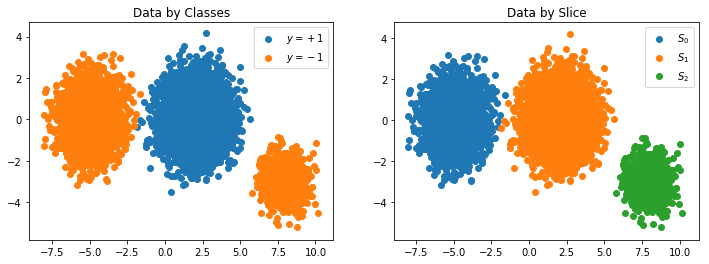

In [4]:
from synthetics_utils import generate_multi_mode_data, generate_label_matrix

# num simulated examples
N = 10000

# mus: [list of d-dim np.arrays] centers of the modes
mus = [
    np.array([-5, 0]), # Mode 1: Y = -1
    np.array([2, 0]), # Mode 2: Y = 1
    np.array([8, -3]) # Mode 3: Y = -1
]
# proportion of data in each mode
props = [0.25, 0.65, 0.1]

# class label of each mode
labels = [-1, 1, -1]

variances = [1, 1, 0.5]

X, Y, C = generate_multi_mode_data(N, mus, props, labels, variances)
S0_idx, S1_idx, S2_idx = np.where(C==0)[0], np.where(C==1)[0], np.where(C==2)[0]

# show data by class and slice
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Data by Classes')
plt.scatter(X[Y==1,0], X[Y==1,1], label="$y=+1$")
plt.scatter(X[Y==-1,0], X[Y==-1,1], label="$y=-1$")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Data by Slice')
plt.scatter(X[C==0,0], X[C==0,1], label="$S_0$")
plt.scatter(X[C==1,0], X[C==1,1], label="$S_1$")
plt.scatter(X[C==2,0], X[C==2,1], label="$S_2$")
plt.legend()
plt.show()

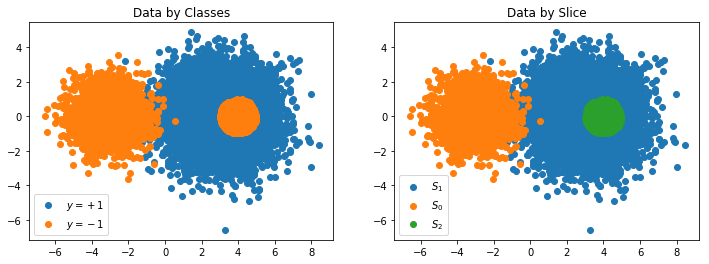

In [5]:
from synthetics_utils import generate_multi_mode_data, generate_label_matrix

# num simulated examples
N = 10000

# mus: [list of d-dim np.arrays] centers of the modes
mus = [
    np.array([-3, 0]), # Mode 1: Y = -1
    np.array([3, 0]), # Mode 2: Y = 1
    np.array([4, 0]) # Mode 3: Y = -1
]
# proportion of data in each mode
props = [0.25, 0.75]

# class label of each mode
labels = [-1, 1]

# variance of each mode
variances = [1, 2]

X, Y, C = generate_multi_mode_data(N, mus, props, labels, variances)

# overwrite head slice 
h = 4
k = 0 
r = 1
circ_idx = np.sqrt((X[:,0] - h)**2 + (X[:,1] - k)**2) < r
C[circ_idx] = 2
Y[circ_idx] = -1

S0_idx, S1_idx, S2_idx = np.where(C==0)[0], np.where(C==1)[0], np.where(C==2)[0]

# make sure there are no points undeneath
# X = X[np.logical_not(circ_idx)]
# Y = Y[np.logical_not(circ_idx)]
# C = C[np.logical_not(circ_idx)]

# show data by class and slice
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Data by Classes')
plt.scatter(X[Y==1,0], X[Y==1,1], label="$y=+1$")
plt.scatter(X[Y==-1,0], X[Y==-1,1], label="$y=-1$")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Data by Slice')
plt.scatter(X[C==1,0], X[C==1,1], label="$S_1$")
plt.scatter(X[C==0,0], X[C==0,1], label="$S_0$")
plt.scatter(X[C==2,0], X[C==2,1], label="$S_2$")
plt.legend()
plt.show()

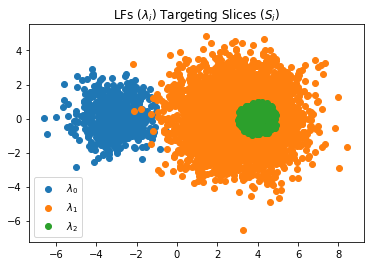

In [6]:
# "simulated" accuracies and coverage of LFs
accs = np.array([0.75, 0.75, 0.75])
covs = np.array([0.9, 0.9, 0.9])

# overlap between primary "torso" LF and "head" LFs
overlap_portion = 0.1

# labeling function generation
L, overlap_idx = generate_label_matrix(N, accs, covs, Y, C, overlap_portion=overlap_portion)

# LFs targeting slices
plt.title('LFs ($\lambda_i$) Targeting Slices ($S_i$)')
plt.scatter(X[L[:,0]==1,0], X[L[:,0]==1,1], label="$\lambda_0$")
plt.scatter(X[L[:,1]==1,0], X[L[:,1]==1,1], label="$\lambda_1$")
plt.scatter(X[L[:,2]==1,0], X[L[:,2]==1,1], label="$\lambda_2$")
plt.legend()
plt.show()

In [7]:
from simulate import eval_model, train_models

## Vary Head LF Accuracy

In [ ]:
%%time

from tqdm import tqdm_notebook as tqdm
from collections import defaultdict

# to collect scores for all models
baseline_scores, manual_scores, attention_scores = defaultdict(list), defaultdict(list), defaultdict(list)

# overlap portion
op = 0.05

# head accuracies
acc_range = [0.6, 0.7, 0.8, 0.9]
# acc_range = np.linspace(0, 1.0, 5)

covs = np.array([0.9, 0.9, 0.9])

# num trials to re-run each simulation
num_trials = 3

for x in acc_range:
    print (f"Head Accuracy: {x}")
    accs = np.array([0.75, 0.75, x])
    
    for _ in tqdm(range(num_trials)):
        # generate data
 
        X, Y, C = generate_multi_mode_data(N, mus, props, labels, variances)
        L, overlap_idx = generate_label_matrix(N, accs, covs, Y, C, overlap_portion=op)

        # train the models
        baseline_model, manual_model, attention_model = train_models(X, L, accs)

        # score the models
        S0_idx, S1_idx, S2_idx = np.where(C==0)[0], np.where(C==1)[0], np.where(C==2)[0]
        eval_dict = {'overlap': overlap_idx, 'S0': S0_idx, 'S1': S1_idx, 'S2':S2_idx}
        baseline_scores[x].append(eval_model(baseline_model, (X,Y), eval_dict))
        manual_scores[x].append(eval_model(manual_model, (X,Y), eval_dict))
        attention_scores[x].append(eval_model(attention_model, (X,Y), eval_dict))

In [ ]:
results = {
    'baseline': dict(baseline_scores),
    'manual': dict(manual_scores),
    'attention': dict(attention_scores)
}

from synthetics_utils import plot_slice_scores
plot_slice_scores(results, 'S2', xlabel='Head Acc.')
plot_slice_scores(results, 'S1', xlabel='Head Acc.')
plot_slice_scores(results, 'S0', xlabel='Head Acc.')
plot_slice_scores(results, 'overall', xlabel='Head Acc.')
plot_slice_scores(results, 'overlap', xlabel='Head Acc.')